# Pix2pix model training

## Environment initialization

First, let's clone pix2pix implementation repo:

In [ ]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git

And then, create a conda environment with the given environment.yml:

In [ ]:
!conda env create -f pytorch-CycleGAN-and-pix2pix/environment.yml

And activate it:

In [ ]:
!conda activate pytorch-CycleGAN-and-pix2pix

## Preparing the dataset

The end goal here is to combine and place our dataset images in a format the pix2pix library can work with. In practice, this should be a folder with the following structure:
- `train/` subdirectory
    - combined training images inside, naming convention: starting from 0, numerical order maintained. (0.png, 1.png, 2.png, 3.png, etc.)
- `val/` subdirectory
    - combined validation images inside, naming convention: starting from 0, numerical order maintained. (0.png, 1.png, 2.png, 3.png, etc.)
- `test/` subdirectory
    - combined images for testing, same naming convention. this is optional and I don't use it for now.

### Step zero
You should integrate the dataset images with Boni's data_preprocessor.ipynb. I wouldn't explain it here because you can find it in his Jupyter Notebook.

### Renaming images
While we have the ground truth images with the following naming convention:
- `[dataset part]_[image iteration]_GT_pose_0_thermal.png`
    - for example: 0_1_GT_pose_0_thermal.png

Boni's data preparator names the images in the following way:
- `[dataset part]_[image iteration]_integral_[focal length].png`
    - for example: 0_1_integral_f0.0.png

It is **very important** to maintain the image iteration numbers here, to make sure the right images are combined later.
Let's rename ground truth files and put them in a different folder:

In [ ]:
import os
import shutil

source_folder = 'your_Part1_folder'
output_folder = 'dataset/groundtruth'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

def rename_and_copy_files():
    for filename in os.listdir(source_folder):
        if filename.startswith("0_") and filename.endswith("_GT_pose_0_thermal.png"):
            # Extract the number from the filename
            number = filename.split('_')[1]
            new_filename = f"{number}.png"
            # Copy and rename the file
            shutil.copy(os.path.join(source_folder, filename), os.path.join(output_folder, new_filename))

# Execute the function
rename_and_copy_files()

And then for the integral images. Note that I only copied images with focal length `0.0` for now.

In [ ]:
import os
import shutil

# Source and destination folder paths
source_folder = 'your_integrals_images_folder'
output_folder = 'dataset/input'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Function to rename and copy files
def rename_and_copy_files():
    for filename in os.listdir(source_folder):
        if filename.startswith("0_") and filename.endswith("_integral_f0.0.png"):
            # Extract the number from the filename
            number = filename.split('_')[1]
            new_filename = f"{number}.png"
            # Copy and rename the file
            shutil.copy(os.path.join(source_folder, filename), os.path.join(output_folder, new_filename))

# Execute the function
rename_and_copy_files()

### Combining the images
First, we have to combine our input and ground truth images to a format that pix2pix can work with. This is essentially putting the ground truth and the input image next to each other into one file: **(warning, maintaining this order is important!)**

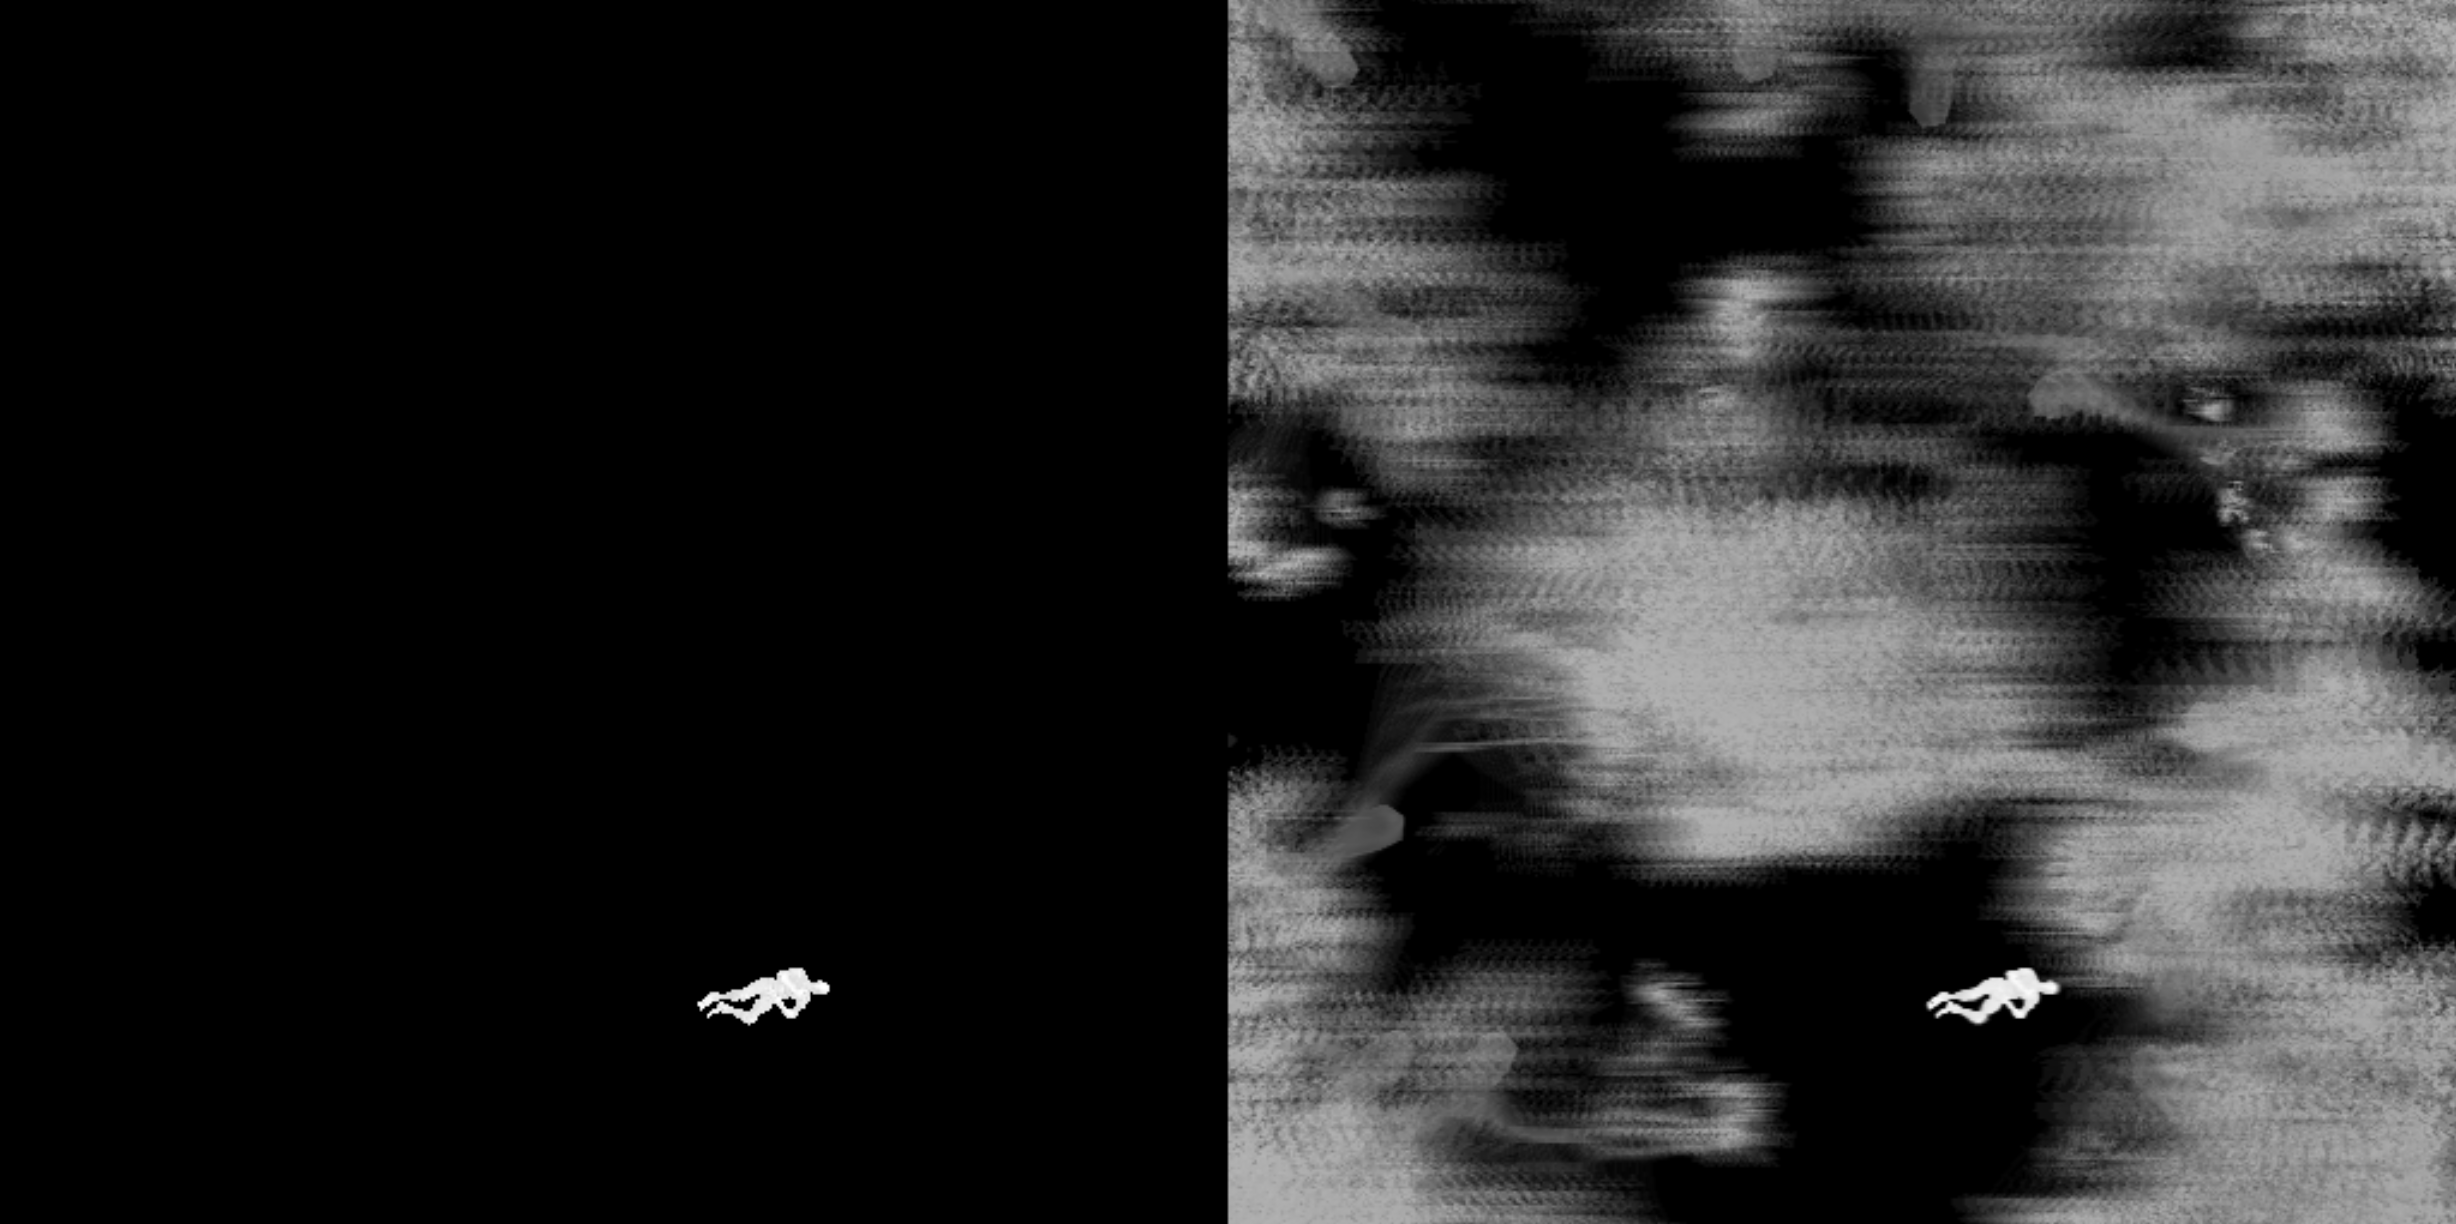

Fortunately, their implementation has an implementation for combining images. Let's do that:

In [ ]:
python pytorch-CycleGAN-and-pix2pix/combine_A_and_B.py --fold_A dataset/groundtruth --fold_B dataset/input --fold_AB dataset/combined

### Splitting the dataset up

As we have a bunch of images now, we should split it up for train and validation images. You can set train_size variable to determine how many of the images should be for training. 

In [ ]:
import os
import shutil

def copy_files(src_folder, train_folder, val_folder, train_size):
    # Ensure source folder exists
    if not os.path.exists(src_folder):
        print(f"Source folder {src_folder} not found.")
        return

    # Create train and val folders if they don't exist
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(val_folder, exist_ok=True)

    # List all files in the source folder
    files = [f for f in os.listdir(src_folder) if os.path.isfile(os.path.join(src_folder, f))]
    files.sort()  # Sort files to ensure consistent order

    for file in files[:train_size]:
        shutil.copy(os.path.join(src_folder, file), train_folder)

    for file in files[train_size:]:
        shutil.copy(os.path.join(src_folder, file), val_folder)

    print("Files copied successfully.")

# Usage
src_folder = 'dataset/combined'
train_folder = 'dataset_pix2pix/train'
val_folder = 'dataset_pix2pix/val'
train_size = 4500  # Number of files to copy to train folder

copy_files(src_folder, train_folder, val_folder, train_size)

## Training the model

Run this command to start training the model:

In [ ]:
python pytorch-CycleGAN-and-pix2pix/train.py --dataroot dataset_pix2pix --name thermal_pix2pix --model pix2pix --direction BtoA

By default, it will start with 200 epochs. That, on my GPU server took like half a day, so on CPU I believe it's impossibly slow to gain anything useful.
Temporary results will be in the `pytorch-CycleGAN-and-pix2pix/checkpoints/thermal_pix2pix` folder.

To continue training, use the `--continue_train` and `--epoch_count` flags, latter to specify where you left off. Otherwise it starts from 0.

In [ ]:
python pytorch-CycleGAN-and-pix2pix/train.py --dataroot dataset_pix2pix --name thermal_pix2pix --model pix2pix --direction BtoA --continue_train --epoch_count 15